# **Setting up the environment**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

# **Importing the data**

In [3]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
dataset_size

3670

In [5]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

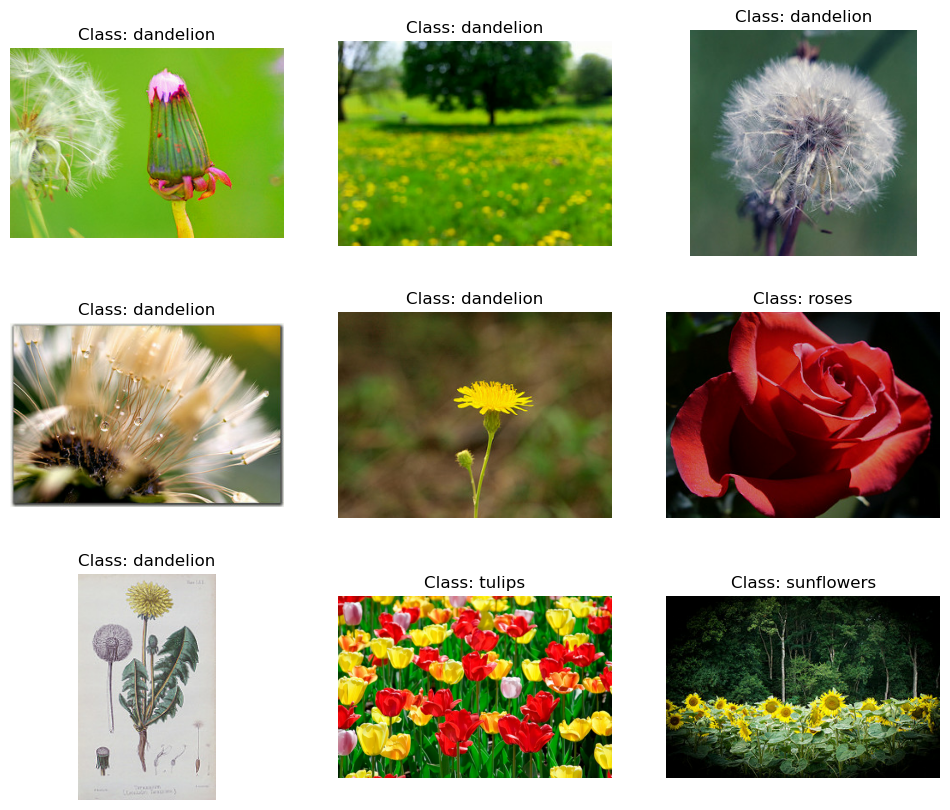

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()


# **Data preprocessing**

In [8]:
# We are resizing the images to (224,224) as Xception model expects 224 x 224 pixel images

tf.keras.backend.clear_session()

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

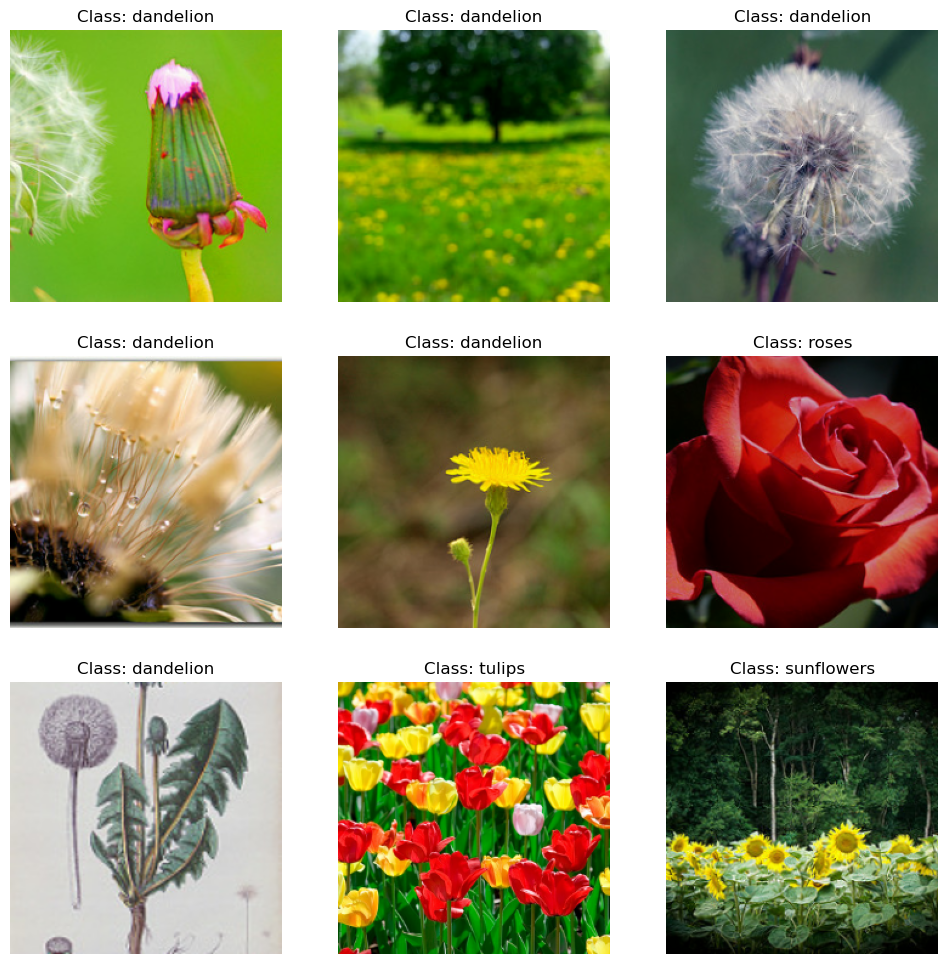

In [9]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

# **Data augmentation**

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

# **Xception**

In [11]:
tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 1s 0us/step


In [12]:
# It's usually a good idea to freeze the weights of the pretrained layers , at least at the beginning

for layer in base_model.layers:
    layer.trainable = False

# **CNN Architecture**

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

# **Base training (freezed weights)**

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
86/86 [==============================] - 29s 196ms/step - loss: 0.7280 - accuracy: 0.8121 - val_loss: 0.6829 - val_accuracy: 0.8403
Epoch 2/5
86/86 [==============================] - 14s 154ms/step - loss: 0.3170 - accuracy: 0.9153 - val_loss: 0.5294 - val_accuracy: 0.8820
Epoch 3/5
86/86 [==============================] - 15s 161ms/step - loss: 0.2042 - accuracy: 0.9331 - val_loss: 0.5421 - val_accuracy: 0.8657
Epoch 4/5
86/86 [==============================] - 15s 165ms/step - loss: 0.1061 - accuracy: 0.9637 - val_loss: 0.6302 - val_accuracy: 0.8421
Epoch 5/5
86/86 [==============================] - 15s 169ms/step - loss: 0.0663 - accuracy: 0.9771 - val_loss: 0.5912 - val_accuracy: 0.8838


In [15]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

# **Training (unfreezed weights)**

In [16]:
# We are unfreezing the weights and training again (we unfreeze some of the base model's top layers)

for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 42s 348ms/step - loss: 0.2821 - accuracy: 0.9139 - val_loss: 0.3945 - val_accuracy: 0.8730
Epoch 2/10
86/86 [==============================] - 29s 326ms/step - loss: 0.0392 - accuracy: 0.9869 - val_loss: 0.3632 - val_accuracy: 0.9056
Epoch 3/10
86/86 [==============================] - 29s 322ms/step - loss: 0.0288 - accuracy: 0.9927 - val_loss: 0.3512 - val_accuracy: 0.9111
Epoch 4/10
86/86 [==============================] - 29s 329ms/step - loss: 0.0074 - accuracy: 0.9982 - val_loss: 0.3266 - val_accuracy: 0.9147
Epoch 5/10
86/86 [==============================] - 29s 326ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.3638 - val_accuracy: 0.9129
Epoch 6/10
86/86 [==============================] - 29s 325ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.3381 - val_accuracy: 0.9201
Epoch 7/10
86/86 [==============================] - 29s 328ms/step - loss: 0.0069 - accuracy: 0.9982 - val_loss: 0.3532 - val_accuracy: 0.9129

In [17]:
score = model.evaluate(test_set)

12/12 [==============================] - 3s 203ms/step - loss: 0.3070 - accuracy: 0.9237


In [18]:
print('Test Accuracy : {:.4f} %'.format(score[1]*100))

Test Accuracy : 92.3706 %


# **Error analysis**

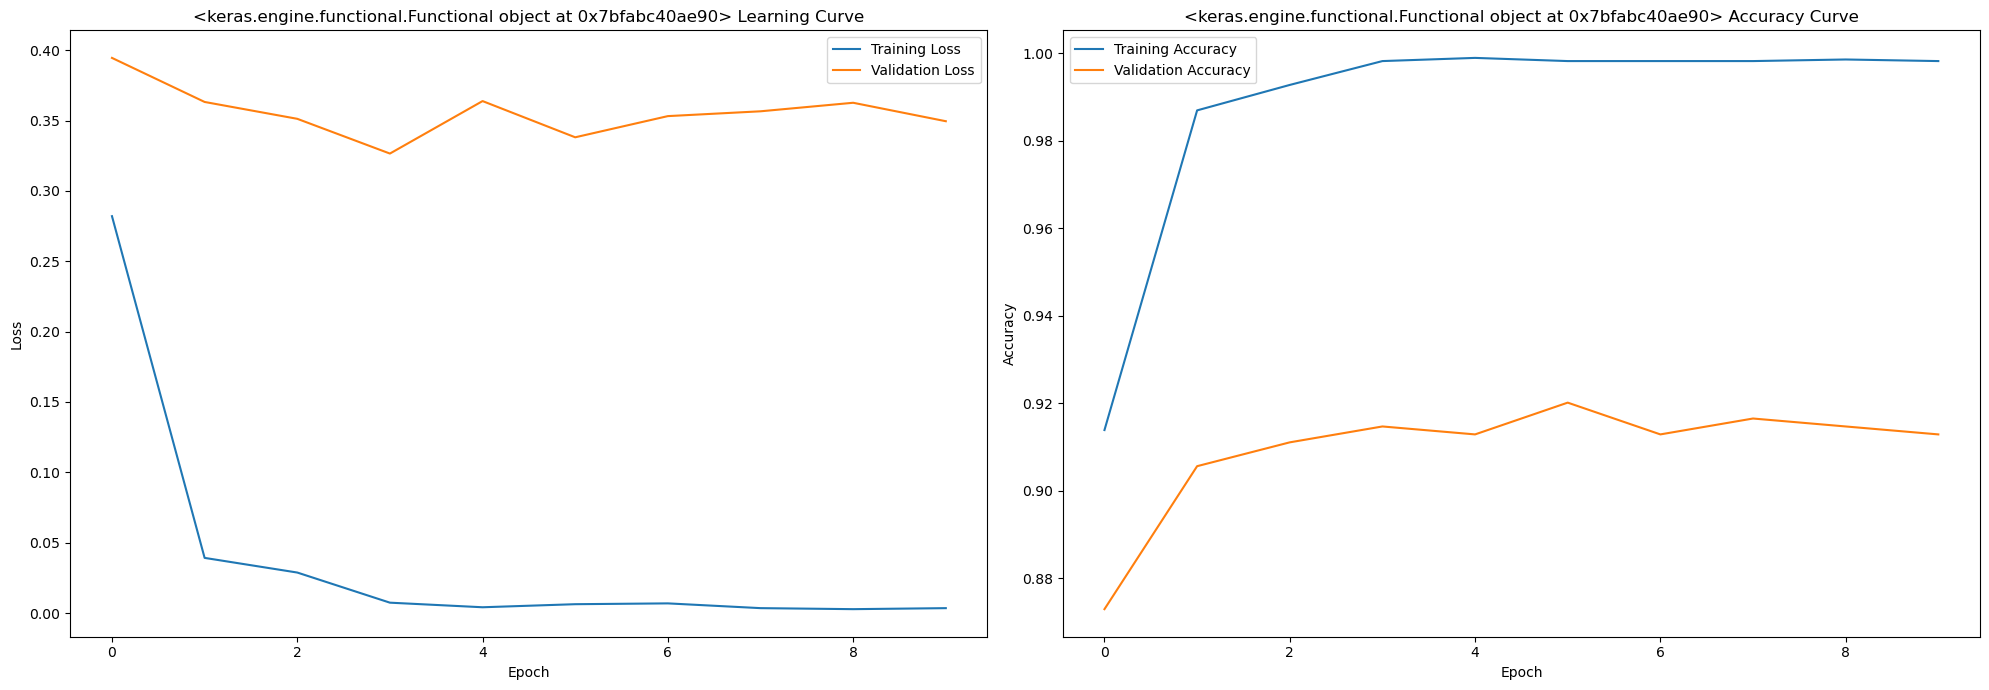

In [19]:
def plot_learning_curves(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Learning Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

def plot_accuracy_curves(history, model_name, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(f'{model_name} Accuracy Curve')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 7))  
plot_learning_curves(history, model, axs[0])
plot_accuracy_curves(history, model, axs[1])

plt.tight_layout()
plt.show()